# Notebook for analysing all VR trials of one experimental group from REINFORCEMENT TEST trials

## Assumes use of FlyOver version 9.4 or higher (closed-loop optogenetic stimulation possible)
## Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [1]:
__author__ = 'Hannah Haberkern, hjmhaberkern@gmail.com'

import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/flyVRoptogenetics/')
from flyVRoptogenetics_oneTrialBasicAnalysis import singleVROptogenTrialAnalysis

path.insert(1, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import makeNestedPlotDirectory, myAxisTheme
from objectInteractionPlots import residencyWithHistograms_splitOnWalking, residencyWithHistograms,\
        radDistAngleCombiPlot, plotResidencyInMiniarena, make4ValuePolCoordPlot

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from trajectoryDerivedParams import relationToObject, cartesian2polar, polarCurvature
from plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df, plotVeloHeadingDistribution2_flyVR_df,\
                               oneDimResidency_df, turnRatePerDistance

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import rZoneParamsFromLogFile

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [3]:
#expDirs = expDirs[:20]
#from operator import itemgetter
#my_indices = [1,3,4,9,14,18] #[1,2,3,4,5,9,10,14,15,17,18]
#expDirs = itemgetter(*my_indices)(expDirs)

### Compose mutli-fly data into dataframe

In [13]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

In [14]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [15]:
keylist = ['curvature','gamma','gammaFull','headingAngle','objectDistance','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

nTrialsVI = 0
nTrialsIN = 0
nTrialsR = 0
nTrialsNR = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[4]
        genotype = fileToAnalyse.split('_')[3]
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleVROptogenTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'Invisible' in fileToAnalyse or 'invisible' in fileToAnalyse:
            trialtype = 'invisible'
            nTrialsIN += 1
        else:
            trialtype = 'visible'
            nTrialsVI += 1
        
        if 'rZones' in fileToAnalyse:
            rZones = 'on'
            nTrialsR += 1
        else:
            rZones = 'off'
            nTrialsNR += 1
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver094/circularVHeatZones/lowContrastGround/SS01159_x_20CsChrWTB_retinal/males/rawData/m01/

 Analysing the following log files:

['singleObjectForestLC_1cm4cmCone_12cmHex_SS01159x20CsChrWTB_m01_6d_none_out_160205180548.txt', 'singleObjectForestLC_1cm4cmCone_12cmHex_SS01159x20CsChrWTB_m01_6d_none_out_160205182916.txt', 'singleObjectForestLC_1cm4cmCone_12cmHex_SS01159x20CsChrWTB_m01_6d_rZones_out_160205181731.txt', 'singleObjectForestLC_1cm4cmInvisibleCone_12cmHex_SS01159x20CsChrWTB_m01_6d_rZones_out_160205184257.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver094/circularVHeatZones/lowContrastGround/SS01159_x_20CsChrWTB_retinal/males/rawData/m02/

 Analysing the following log files:

['singleObjectForestLC_1cm4cmCone_12cmHex_SS0115

In [16]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df 

flyID trial trialtype reinforcement  moving  curvature  gamma  \
0       m01     1   visible           off       1        NaN    NaN   
1       m01     1   visible           off       1        NaN    NaN   
2       m01     1   visible           off       1        NaN    NaN   
3       m01     1   visible           off       1        NaN    NaN   
4       m01     1   visible           off       1        NaN    NaN   
5       m01     1   visible           off       1        NaN    NaN   
6       m01     1   visible           off       1        NaN    NaN   
7       m01     1   visible           off       1        NaN    NaN   
8       m01     1   visible           off       1        NaN    NaN   
9       m01     1   visible           off       1        NaN    NaN   
10      m01     1   visible           off       1        NaN    NaN   
11      m01     1   visible           off       1        NaN    NaN   
12      m01     1   visible           off       1        NaN    NaN   
13      m01     1   visible           off       1        NaN    NaN   
14      m01     1   visible           off       1        NaN    NaN   
15      m01     1   visible           off       1        NaN    NaN   
16      m01     1   visible           off       1        NaN    NaN   
17      m01     1   visible           off       1        NaN    NaN   
18      m01     1   visible           off       0        NaN    NaN   
19      m01     1   visible           off       1        NaN    NaN   
20      m01     1   visible           off       0        NaN    NaN   
21      m01     1   visible           off       0        NaN    NaN   
22      m01     1   visible           off       0        NaN    NaN   
23      m01     1   visible           off       0        NaN    NaN   
24      m01     1   visible           off       0        NaN    NaN   
25      m01     1   visible           off       0        NaN    NaN   
26      m01     1   visible           off       0        NaN    NaN   
27      m01     1   visible           off       0        NaN    NaN   
28      m01     1   visible           off       0        NaN    NaN   
29      m01     1   visible           off       0        NaN    NaN   
...     ...   ...       ...           ...     ...        ...    ...   
11970   m15     3   visible            on       0        NaN    NaN   
11971   m15     3   visible            on       0        NaN    NaN   
11972   m15     3   visible            on       0        NaN    NaN   
11973   m15     3   visible            on       0        NaN    NaN   
11974   m15     3   visible            on       0        NaN    NaN   
11975   m15     3   visible            on       0        NaN    NaN   
11976   m15     3   visible            on       0        NaN    NaN   
11977   m15     3   visible            on       0        NaN    NaN   
11978   m15     3   visible            on       0        NaN    NaN   
11979   m15     3   visible            on       0        NaN    NaN   
11980   m15     3   visible            on       0        NaN    NaN   
11981   m15     3   visible            on       0        NaN    NaN   
11982   m15     3   visible            on       0        NaN    NaN   
11983   m15     3   visible            on       0        NaN    NaN   
11984   m15     3   visible            on       0        NaN    NaN   
11985   m15     3   visible            on       0        NaN    NaN   
11986   m15     3   visible            on       0        NaN    NaN   
11987   m15     3   visible            on       0        NaN    NaN   
11988   m15     3   visible            on       0        NaN    NaN   
11989   m15     3   visible            on       0        NaN    NaN   
11990   m15     3   visible            on       0        NaN    NaN   
11991   m15     3   visible            on       0        NaN    NaN   
11992   m15     3   visible            on       0        NaN    NaN   
11993   m15     3   visible            on       0        NaN    NaN   
11994   m15     3   visible   

In [17]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_objD = keylistLong.index('objectDistance')

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [19]:
# Reinforcement test
rZoneState = ['off','off','on','on']
visibilityState = ['visible','visible','visible','invisible']
groundPlane = ['textured']
trialOrder = [0,2,1,3]
trialName = ['1','3','2','4']
arenaRad = 60

rZone_rInner, rZone_rOuter, rZone_max, rZone_gExp = rZoneParamsFromLogFile(expDir, fileToAnalyse)

In [20]:
%matplotlib inline 

### Trajectory plots of all trials

/Users/hannah/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


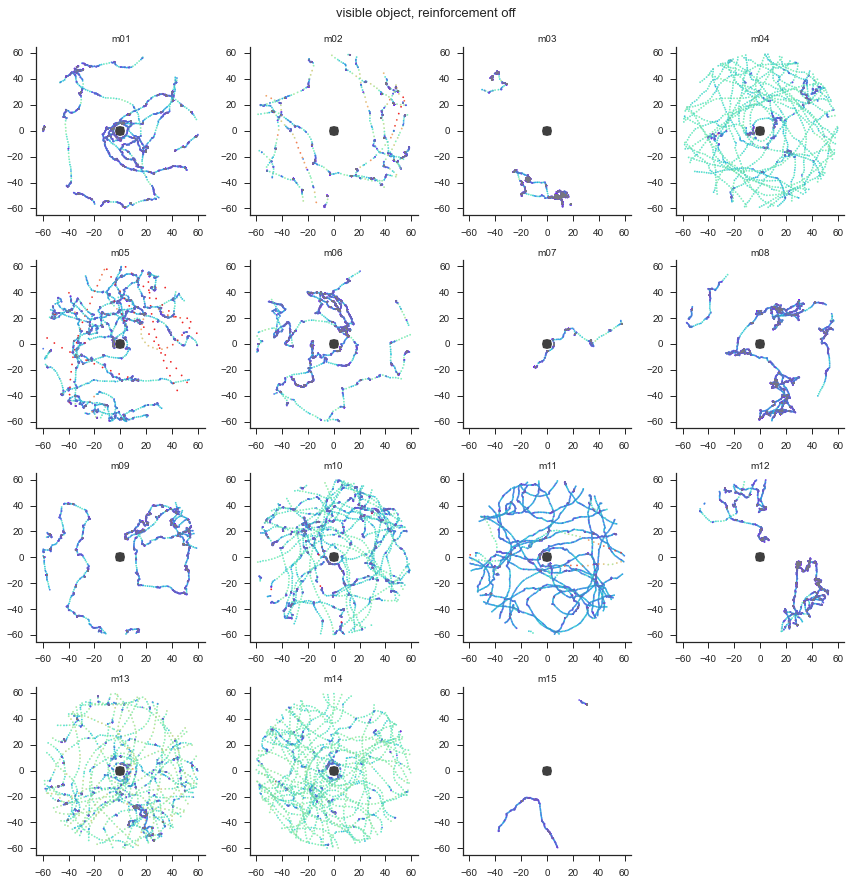

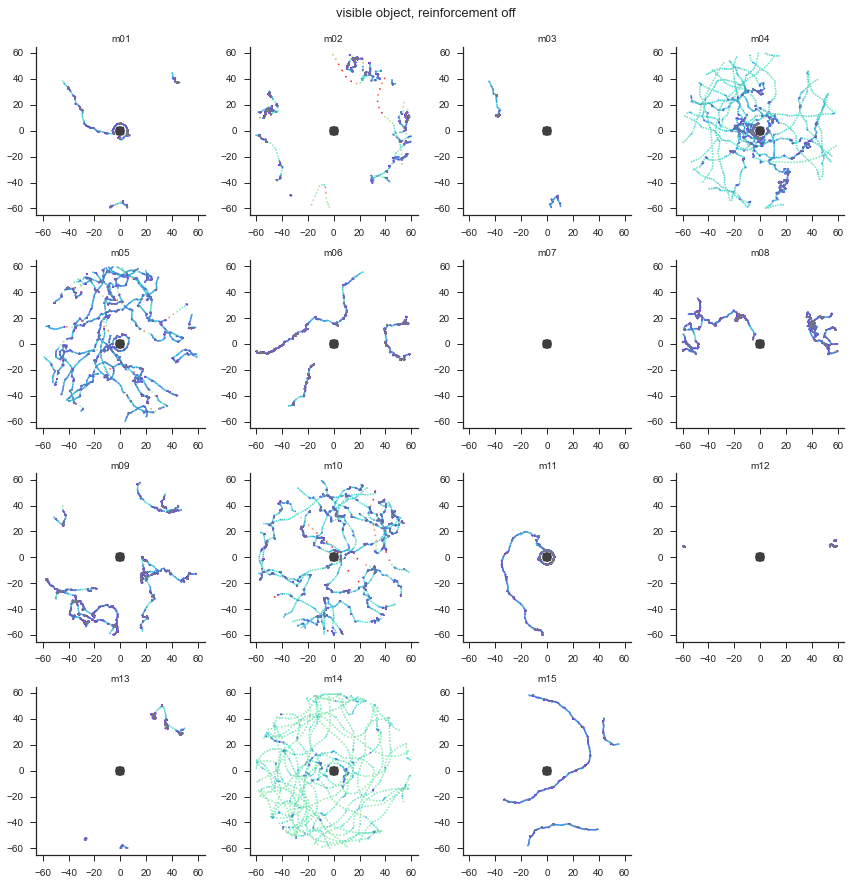

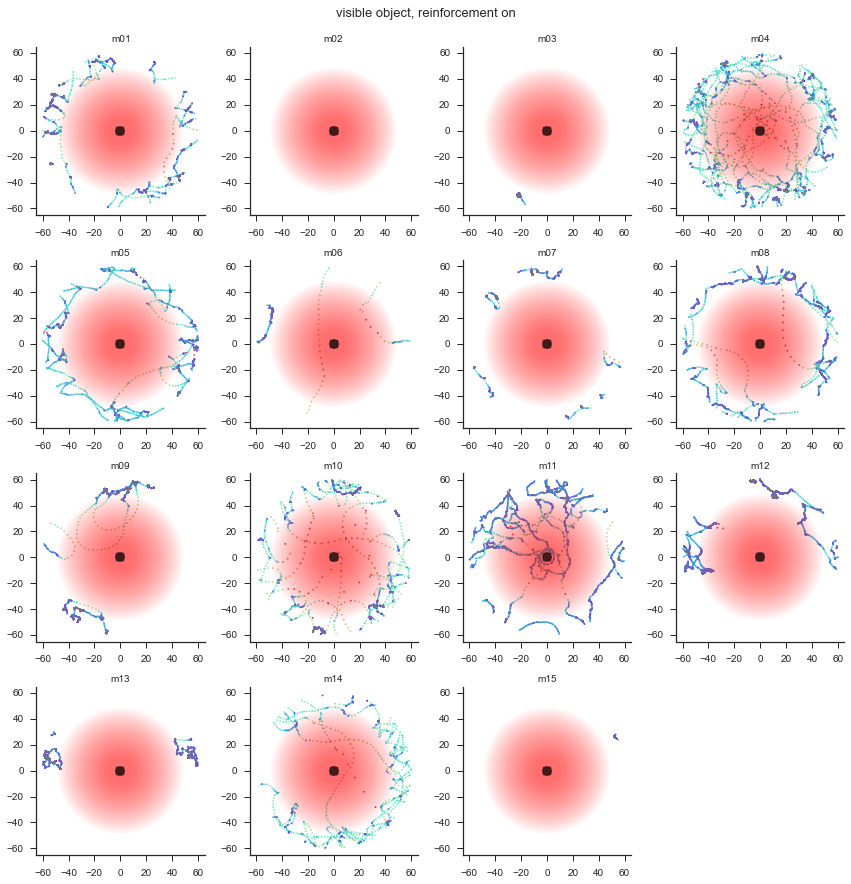

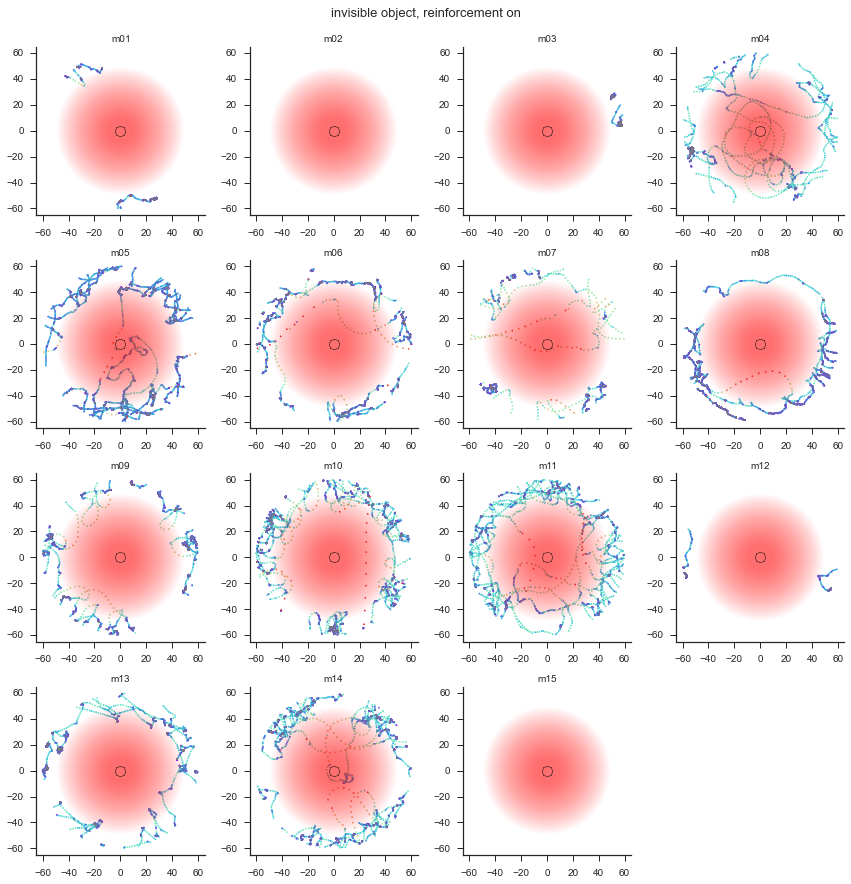

In [21]:
nrows = np.ceil(numFlies/4.0)
for ttind,trialtype in enumerate(visibilityState):
    multiflyTracePlot = plt.figure(figsize=(12,3*nrows))
    figtitle = multiflyTracePlot.suptitle(trialtype + ' object, reinforcement ' + rZoneState[ttind] ,fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(nrows,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (trial==' + str(ttind+1) + ') & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].squeeze()
        perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze()
        
        selectPts = range(0,len(perFlyX),3)
        #color = scalarMap.to_rgba(timecolor), alpha = 0.1)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        
        if (trialtype == 'visible'):
            multiflyTracePlot_sbplt.plot(0, 0, marker='o', markersize=10, linestyle='none', alpha=0.75, color='black')
        else:
            multiflyTracePlot_sbplt.plot(0, 0, marker='o', markersize=10, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor='black')

        if(rZoneState[ttind]=='on'):
            rZoneRange = float(rZone_rOuter - rZone_rInner)
            for zRad in range(rZone_rInner, rZone_rOuter):
                circle1 = plt.Circle((0, 0), zRad, color='r', alpha=1.0/rZoneRange)
                multiflyTracePlot_sbplt.add_artist(circle1)
        
        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-arenaRad-5, arenaRad + 5)
        multiflyTracePlot_sbplt.set_ylim(-arenaRad-5, arenaRad + 5)
        
    multiflyTracePlot.tight_layout()
    
    # analysisDir + 'tracePlotMA/' should already exist from single trial analysis
    # makeNestedPlotDirectory(analysisDir, 'tracePlotMA/', objecttype + sep)
    multiflyTracePlot.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0] +'_'+ trialtype +'_rZones'+ rZoneState[ttind]
                              +'_traceVeloColored_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

### Velocity and relative heading distributions

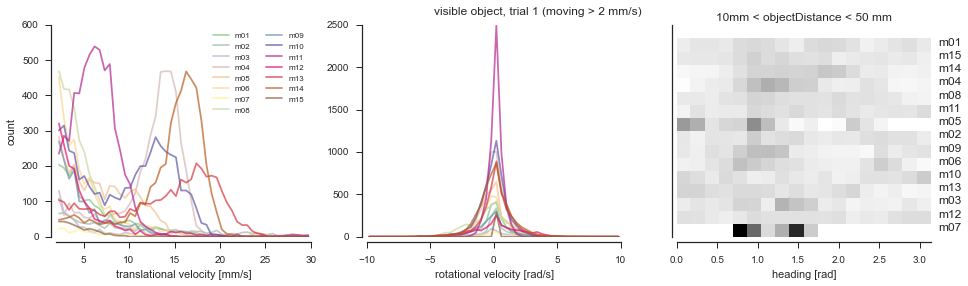

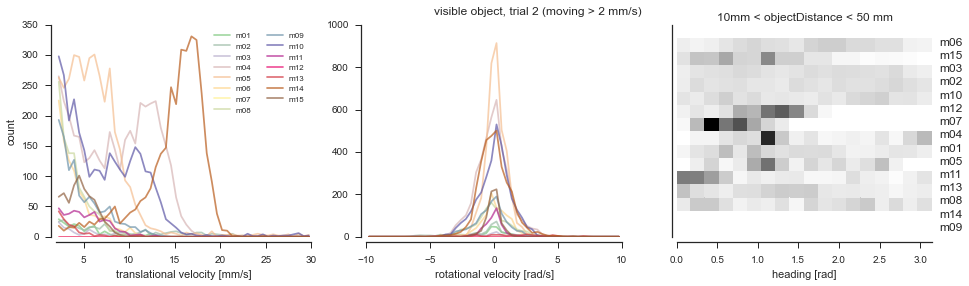

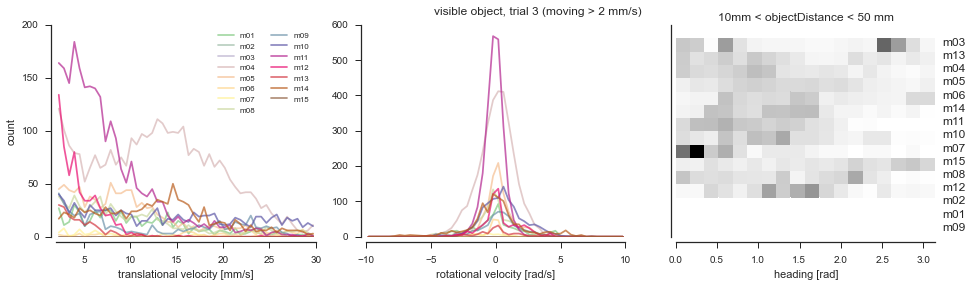

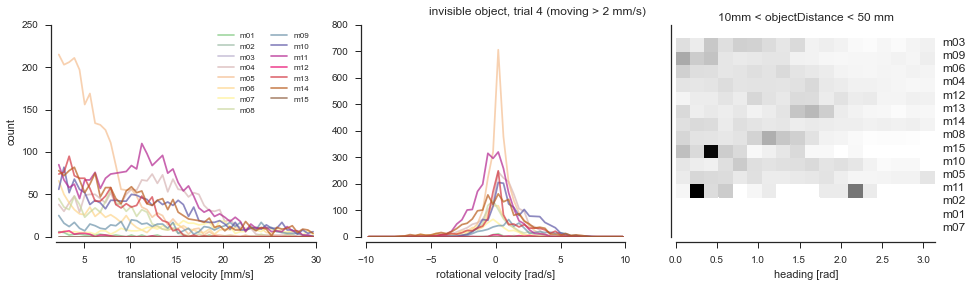

In [22]:
for ttind,trialtype in enumerate(visibilityState):
    
    veloDistFig = plotVeloHeadingDistribution_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong,
                                                       vTransTH, 10, 50)
    veloDistFig.tight_layout()
    
    veloDistFig.savefig(analysisDir + 'velocityTraces/'+ genotype +'_'+flyIDs[0][0]+ '_' + trialtype + '_rZones' + rZoneState[ttind]
                + '_veloDistributions_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

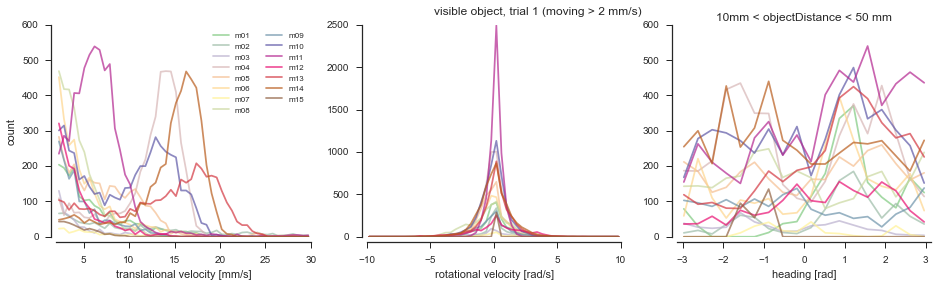

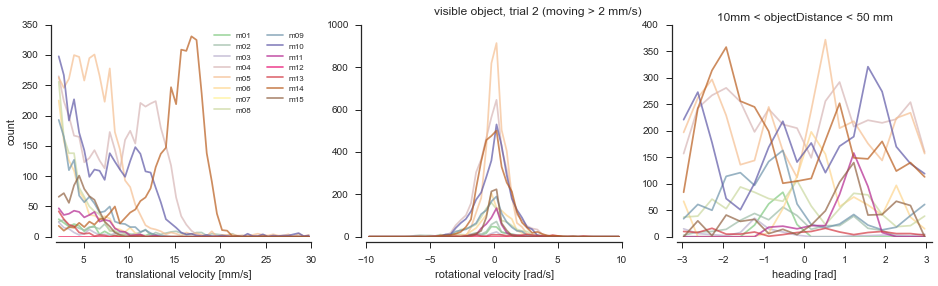

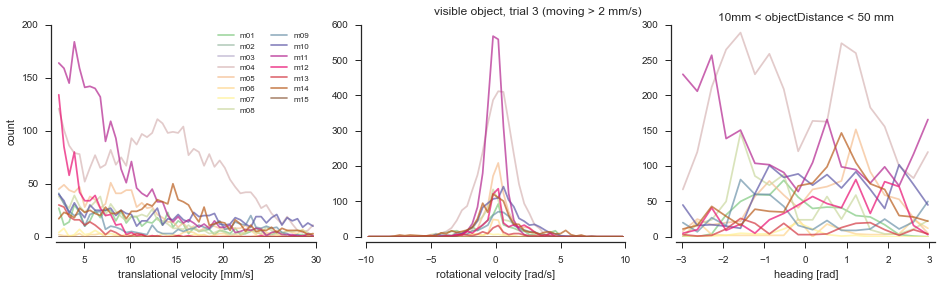

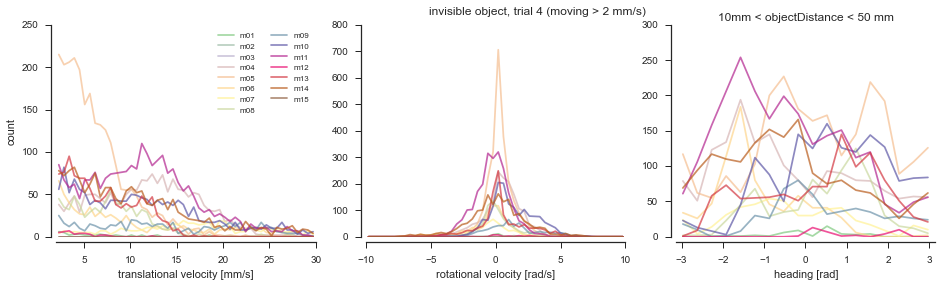

In [23]:
for ttind,trialtype in enumerate(visibilityState):
    
    veloDistFig = plotVeloHeadingDistribution2_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong,
                                                        vTransTH, 10, 50)
    veloDistFig.tight_layout()

    veloDistFig.savefig(analysisDir + 'velocityTraces/'+ genotype +'_'+flyIDs[0][0]+ '_' + trialtype + '_rZones' + rZoneState[ttind]
                + '_veloDistributions2_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

## Residency

### 2D (cartesian) residency

Plot directory already exists
Plot directory already exists
Plot directory already exists
Condition was not tested.


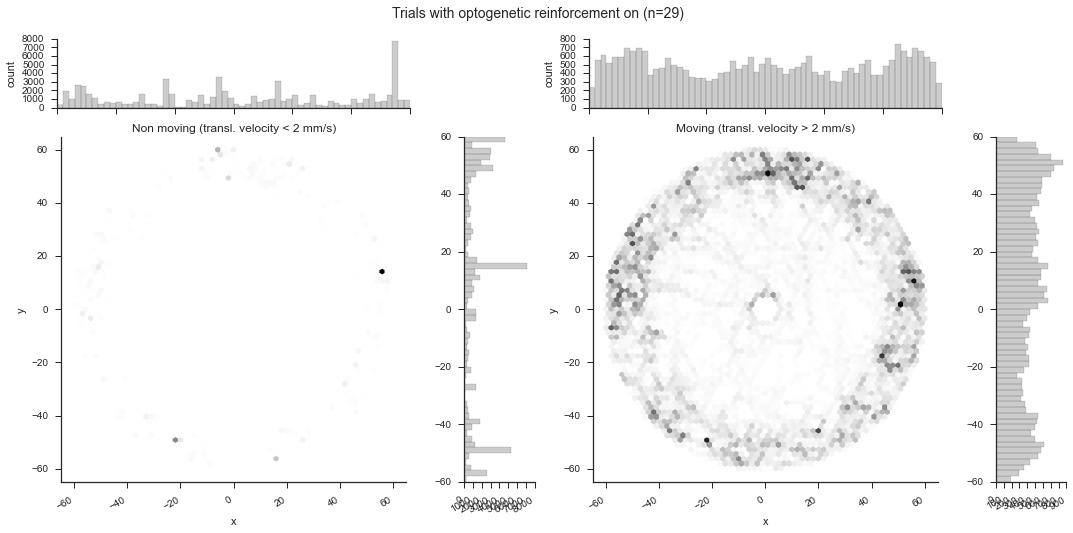

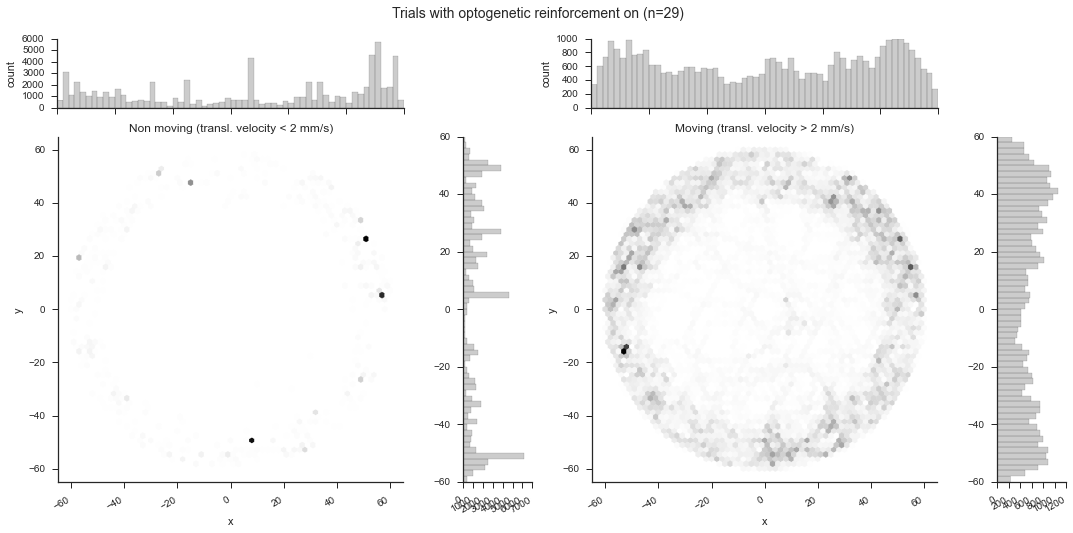

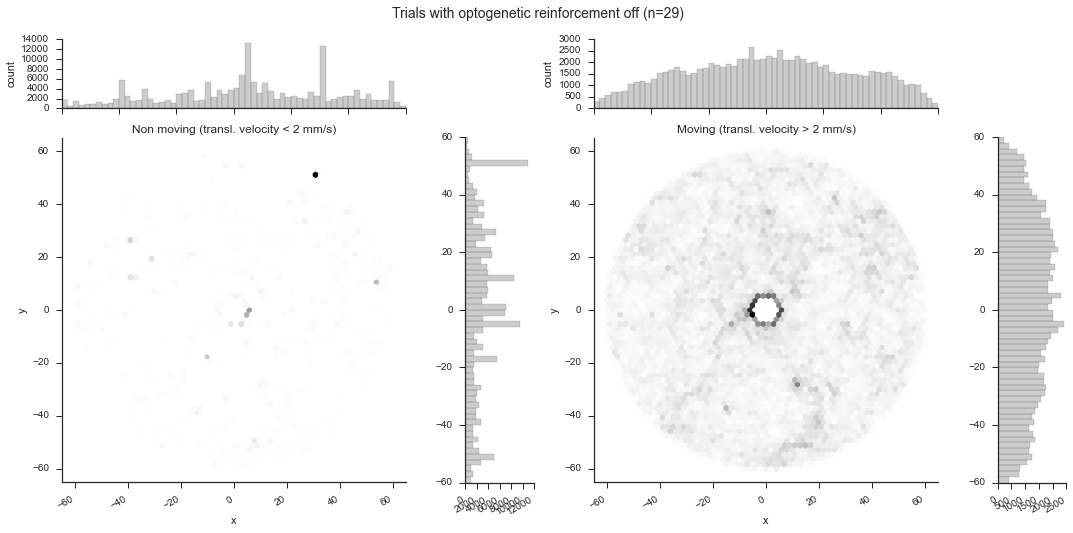

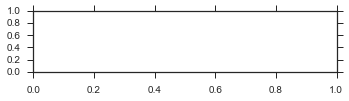

In [24]:
# make fly summary plot of residency:
numBins = 60

keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_vT = keylistLong.index('transVelo')

nTrials = (nTrialsNR,nTrialsR)

for indcond, condition in enumerate(['on','off']):
    for indcond2, condition2 in enumerate(['visible','invisible']):
        querystring = '(reinforcement == "' + condition + '") & (trialtype == "'+condition2+'")'
        try:
            xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
            yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
            movingall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1]).squeeze().astype('bool')
            vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()

            movingall = vT>vTransTH

            # make plot
            noNans = ~np.isnan(xPosMAall)
            hexplotfig = residencyWithHistograms_splitOnWalking(
                xPosMAall[noNans], yPosMAall[noNans], movingall[noNans], arenaRad, numBins, vTransTH,
                'Trials with optogenetic reinforcement ' + condition + ' (n=' + str(nTrials[indcond]) + ')')

            try:
                mkdir(analysisDir + 'residencyPlots/')
            except:
                print('Plot directory already exists')
            hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]+'_rZones' + condition
                     + '_'+condition2+'Object'+'_residencyMA_splitonwaling_n'+ str(len(flyIDs)) +'.pdf', format='pdf')
        except ValueError:
            print('Condition was not tested.')

### 1D (radial) residency

Plot directory already exists


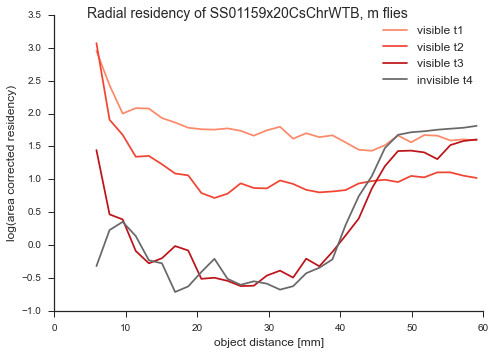

In [25]:
movementFilter = 'moving > 0'
numBins = 30
histRange = (5,arenaRad)

radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)

radResPlt = oneDimResidency_df(radResPlt, FOAllFlies_df, keyind_xPos, keyind_yPos, movementFilter,
                               visibilityState, numBins, histRange,1)
myAxisTheme(radResPlt)
radResFig.tight_layout()

try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidency_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### 2D (polar) residency: heading vs. distance

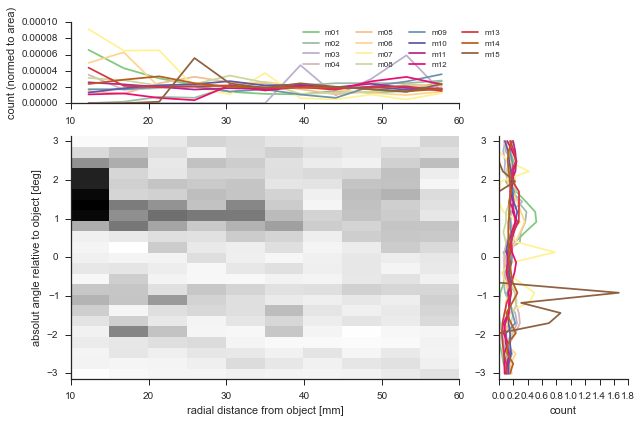

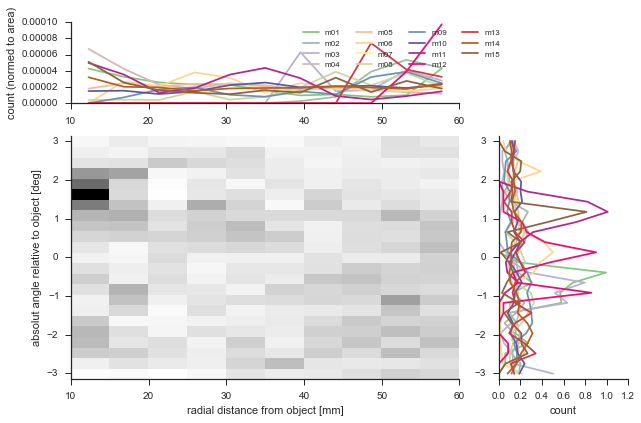

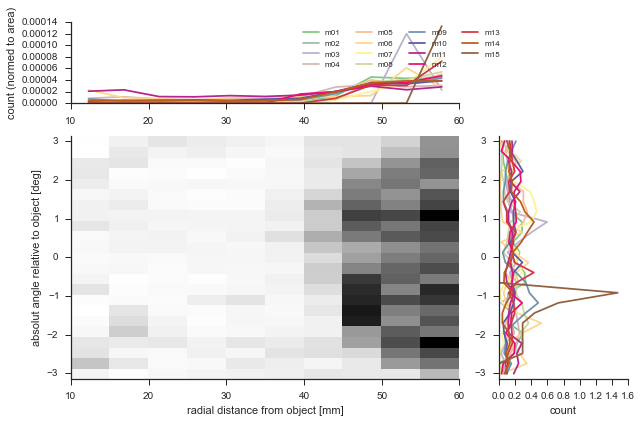

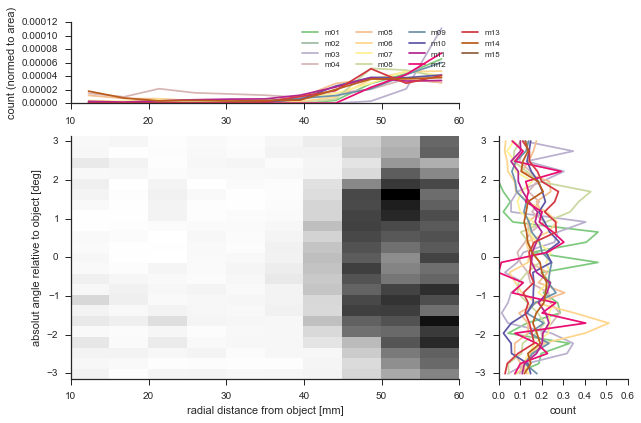

In [26]:
# plot parameter
distBins = 11
angleBins = 24
maxDist = arenaRad
minDist = 10

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(visibilityState):
    querystring = '(trialtype == "'+trialtype+'") & (trial == '+str(ttind+1)+\
        ') & (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistMAall, _ = cartesian2polar(xPosMAall,yPosMAall)

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,minDist,maxDist,flyIDs,flyIDallarray,
                                           objDistMAall,gammaFullall)
    
    headingDistFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                           + '_headingVsDistanceHist_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

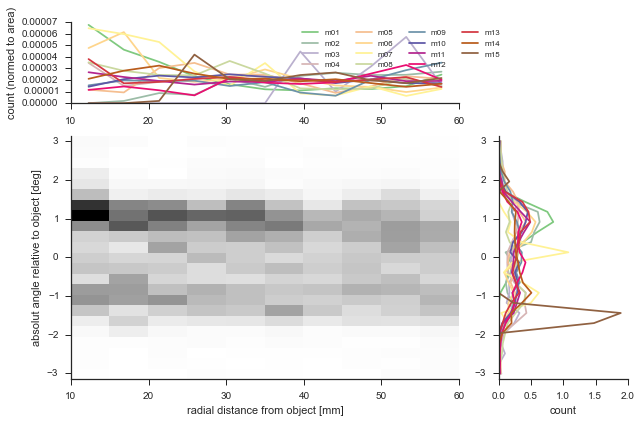

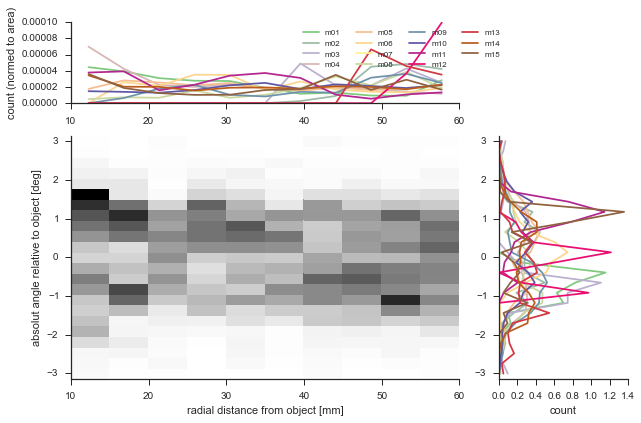

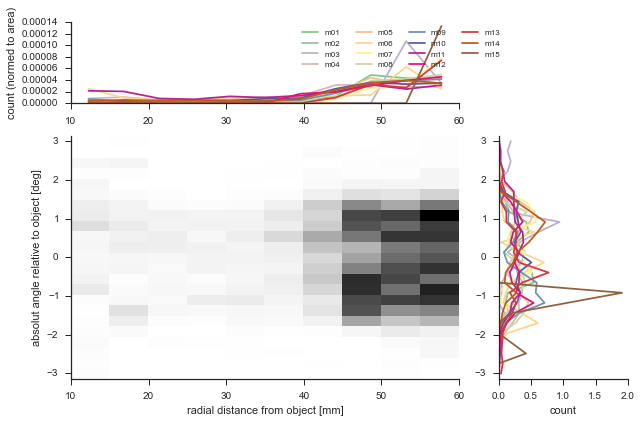

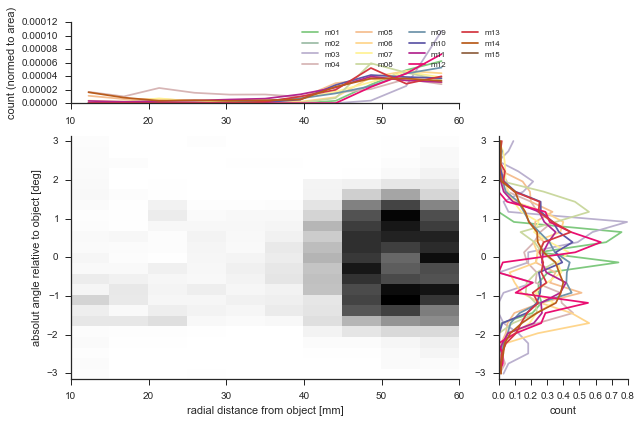

In [27]:
# plot parameter
distBins = 11
angleBins = 24
maxDist = arenaRad
minDist = 10

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(visibilityState):
    querystring = '(trialtype == "'+trialtype+'") & (trial == '+str(ttind+1)+\
        ') & (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistMAall, _ = cartesian2polar(xPosMAall,yPosMAall)
    d_objDist = np.hstack((0, np.diff(np.convolve(objDistMAall, np.ones((7,))/7, mode='same'))))

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,minDist,maxDist,flyIDs,flyIDallarray[d_objDist<0],
                                           objDistMAall[d_objDist<0],gammaFullall[d_objDist<0])
    
    headingDistFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                           + '_headingVsDistanceHist_apr_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

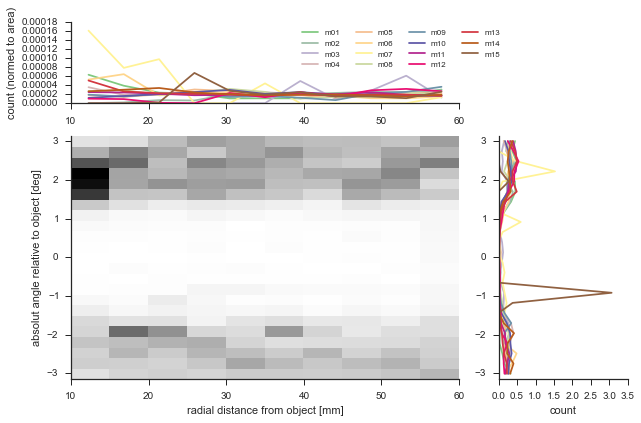

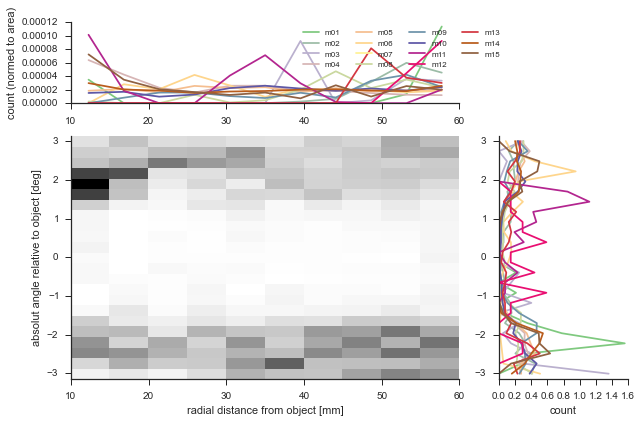

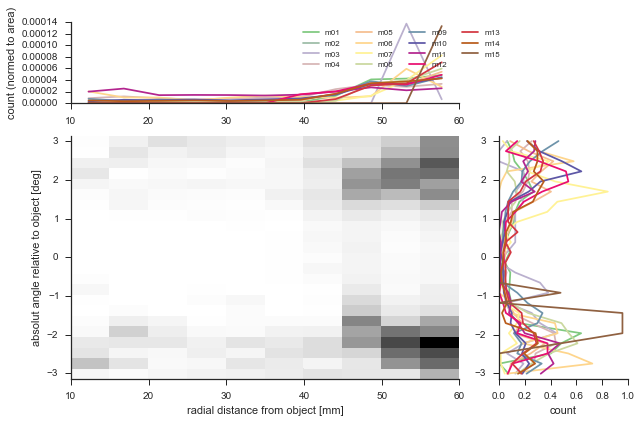

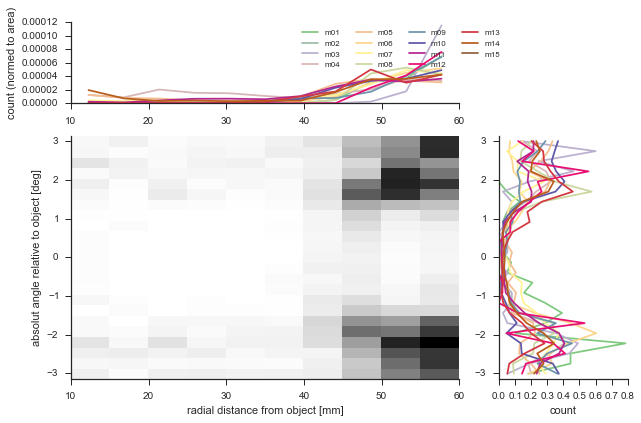

In [28]:
# plot parameter
distBins = 11
angleBins = 24
maxDist = arenaRad
minDist = 10

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(visibilityState):
    querystring = '(trialtype == "'+trialtype+'") & (trial == '+str(ttind+1)+\
        ') & (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistMAall, _ = cartesian2polar(xPosMAall,yPosMAall)
    d_objDist = np.hstack((0, np.diff(np.convolve(objDistMAall, np.ones((7,))/7, mode='same'))))

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,minDist,maxDist,flyIDs,flyIDallarray[d_objDist>0],
                                           objDistMAall[d_objDist>0],gammaFullall[d_objDist>0])
    
    headingDistFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                           + '_headingVsDistanceHist_dep_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

## Analysis of steering maneuvres and their relationship with the object location

### Turnrate relative to object distance

Plot directory already exists


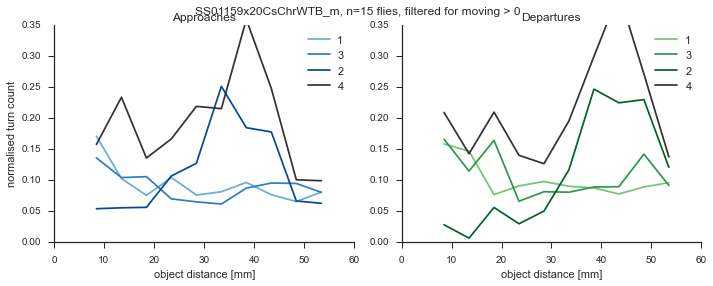

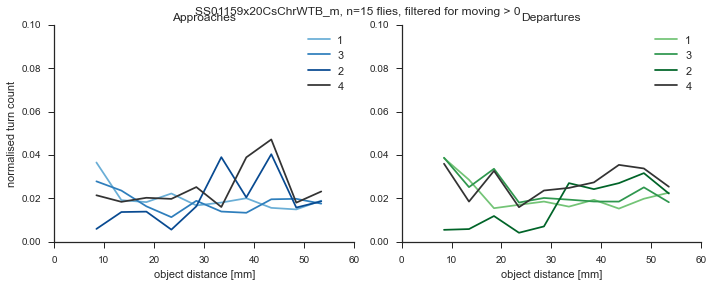

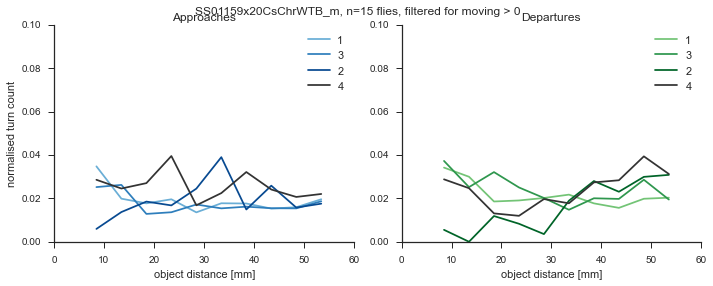

In [29]:
numBins = 10
useTurnIndex = False
movementFilter='moving > 0'

try:
    mkdir(analysisDir + 'turnRates/')
except:
    print('Plot directory already exists')

useTurnChange = 0

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
yLimRange = (0,0.35)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,keylistLong,visibilityState,movementFilter,useTurnIndex,
                          useTurnChange,trialName,yLimRange,numBins,arenaRad)

Fig.savefig(analysisDir + 'turnRates/'+ genotype +'_'+flyIDs[0][0]+
            '_turnRatePerDistance_aboveTH'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

useTurnChange = 1

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
yLimRange = (0,0.1)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,keylistLong,visibilityState,movementFilter,useTurnIndex,
                          useTurnChange,trialName,yLimRange,numBins,arenaRad)

Fig.savefig(analysisDir + 'turnRates/'+ genotype +'_'+flyIDs[0][0]+
            '_turnRatePerDistance_turnStart'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

useTurnChange = -1

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
yLimRange = (0,0.1)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,keylistLong,visibilityState,movementFilter,useTurnIndex,
                          useTurnChange,trialName,yLimRange,numBins,arenaRad)

Fig.savefig(analysisDir + 'turnRates/'+ genotype +'_'+flyIDs[0][0]+
            '_turnRatePerDistance_turnEnd'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

## Polar coord maps of movement parameter

In [30]:
minDist = 6
maxDist = 56
distEdges = np.linspace(minDist, maxDist, 10)
angleEdges = np.linspace(0, np.pi, 9)
fullAngleEdges = np.linspace(-np.pi, np.pi, 36)
maxVals = (12.0,7.0, 1.0, 0.3) #(20.0,10.0, 1.5, 0.3)#

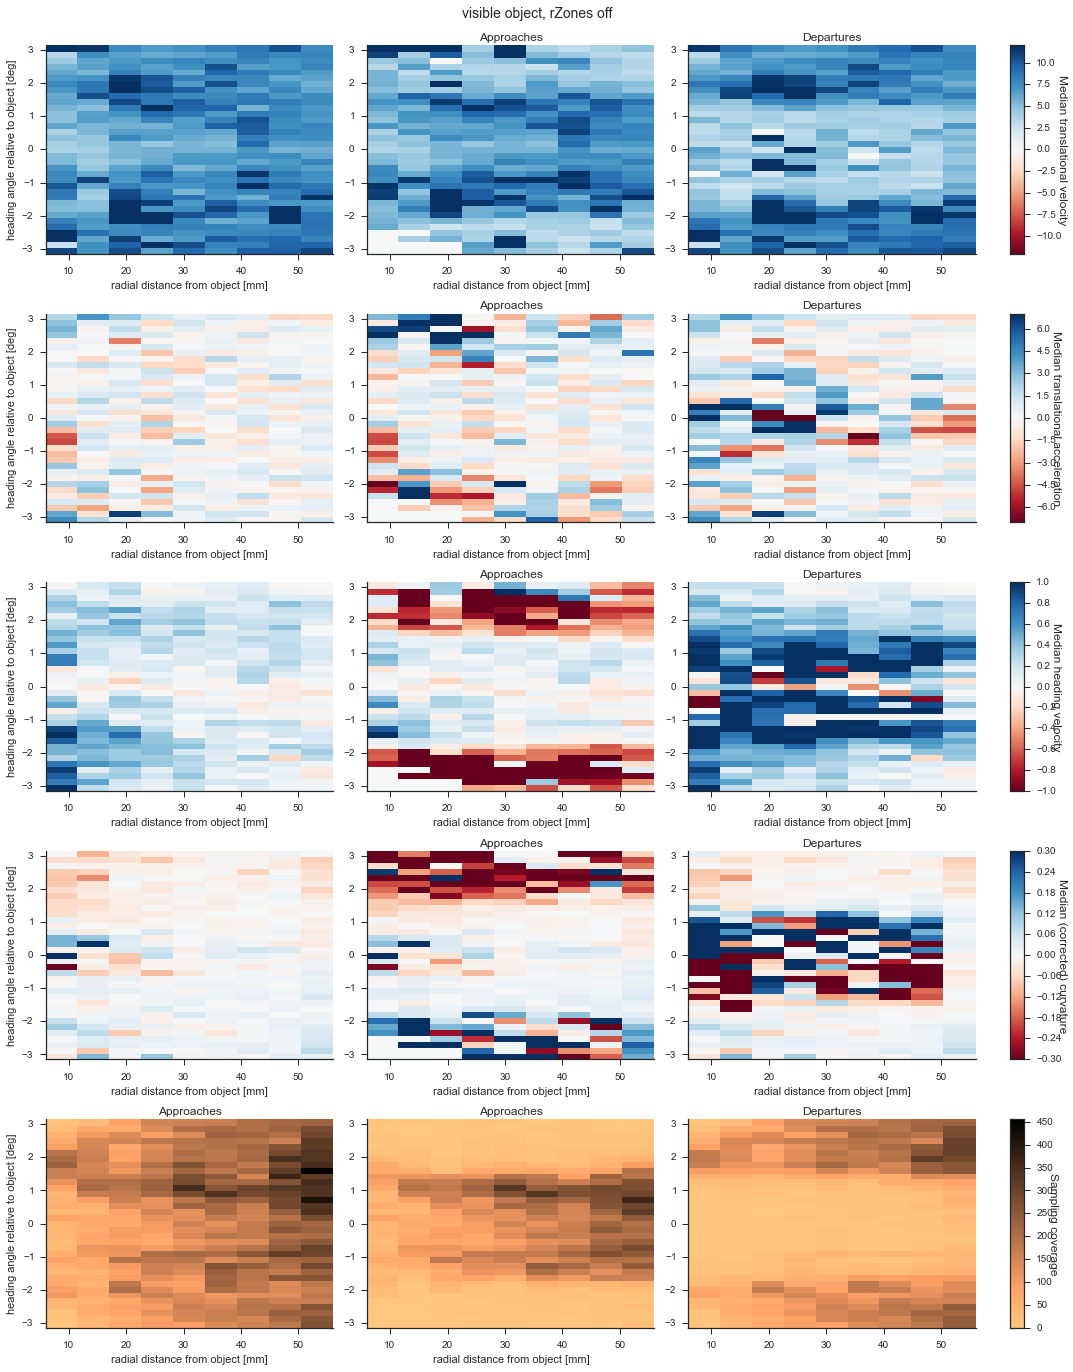

In [31]:
#for tind,trialtype in enumerate(visibilityState):
trial = 1
trialtype = 'visible'
querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, rZones ' + rZoneState[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_'+trialtype+'Objects_rZone'
                      +rZoneState[trial-1]+'_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

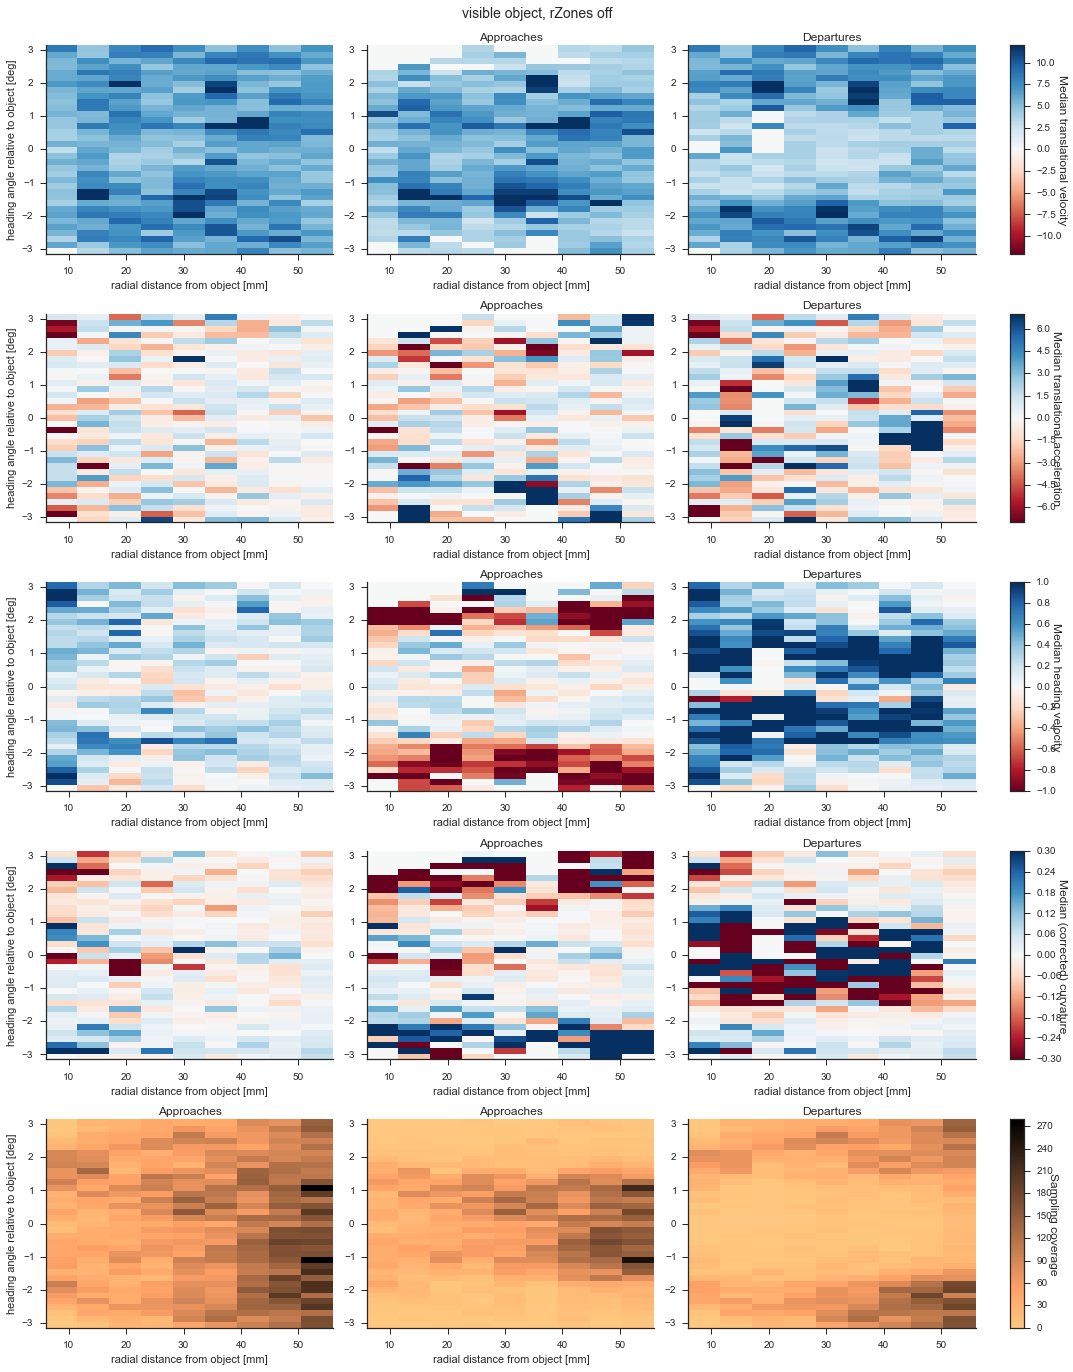

In [32]:
trialtype = 'visible'
trial = 2

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, rZones ' + rZoneState[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_'+trialtype+'Objects_rZone'
                      +rZoneState[trial-1]+'_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

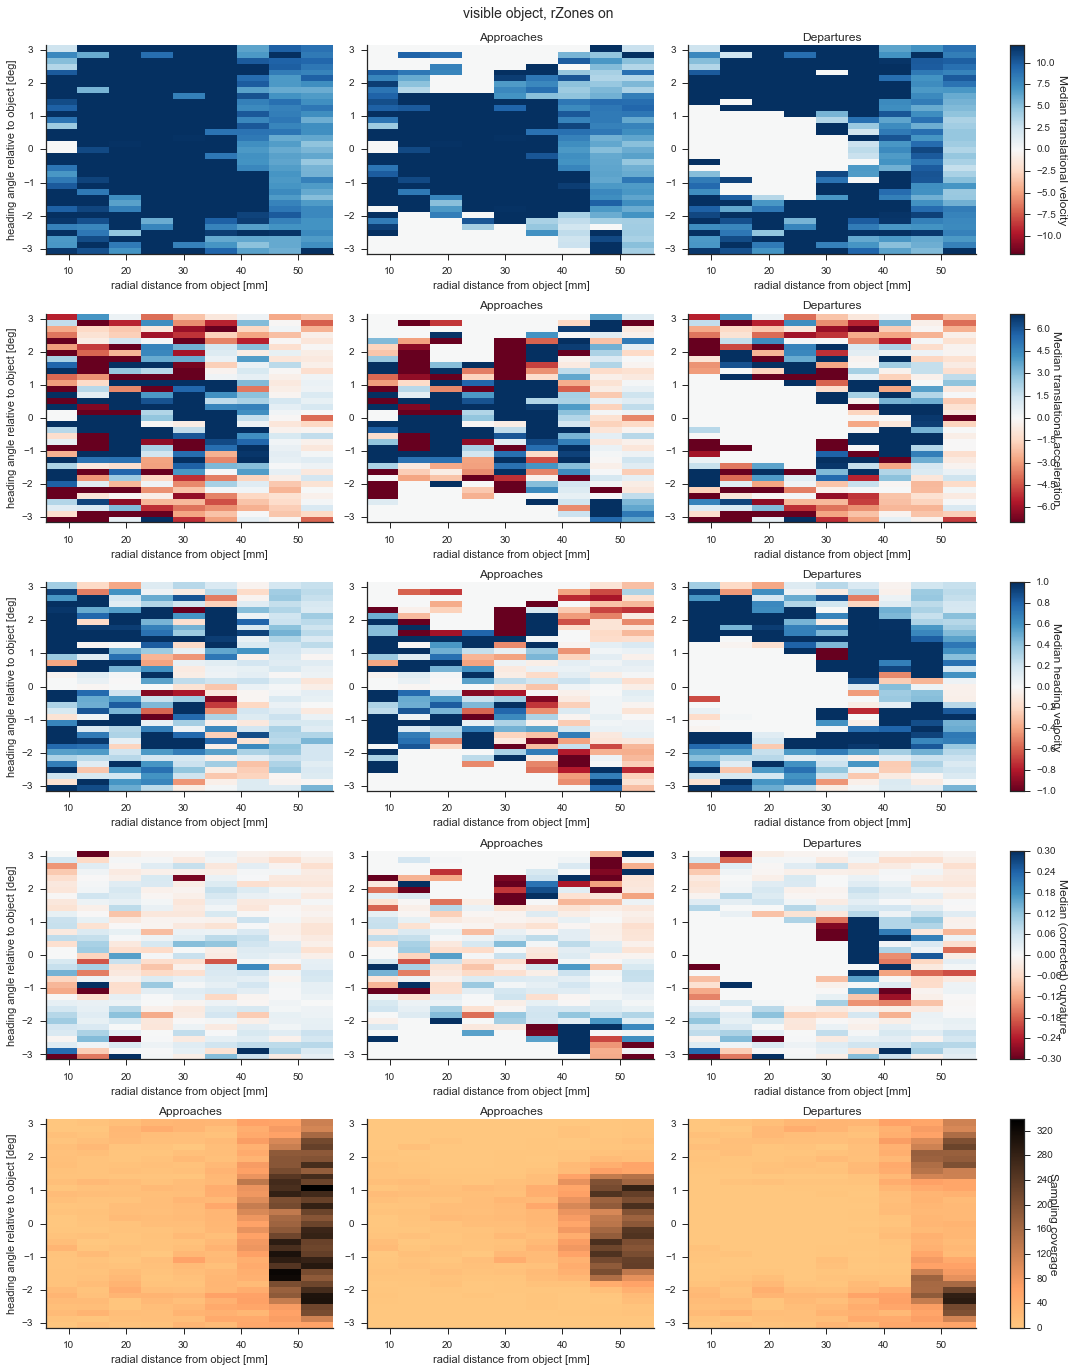

In [33]:
trialtype = 'visible'
trial = 3

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, rZones ' + rZoneState[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_'+trialtype+'Objects_rZone'
                      +rZoneState[trial-1]+'_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

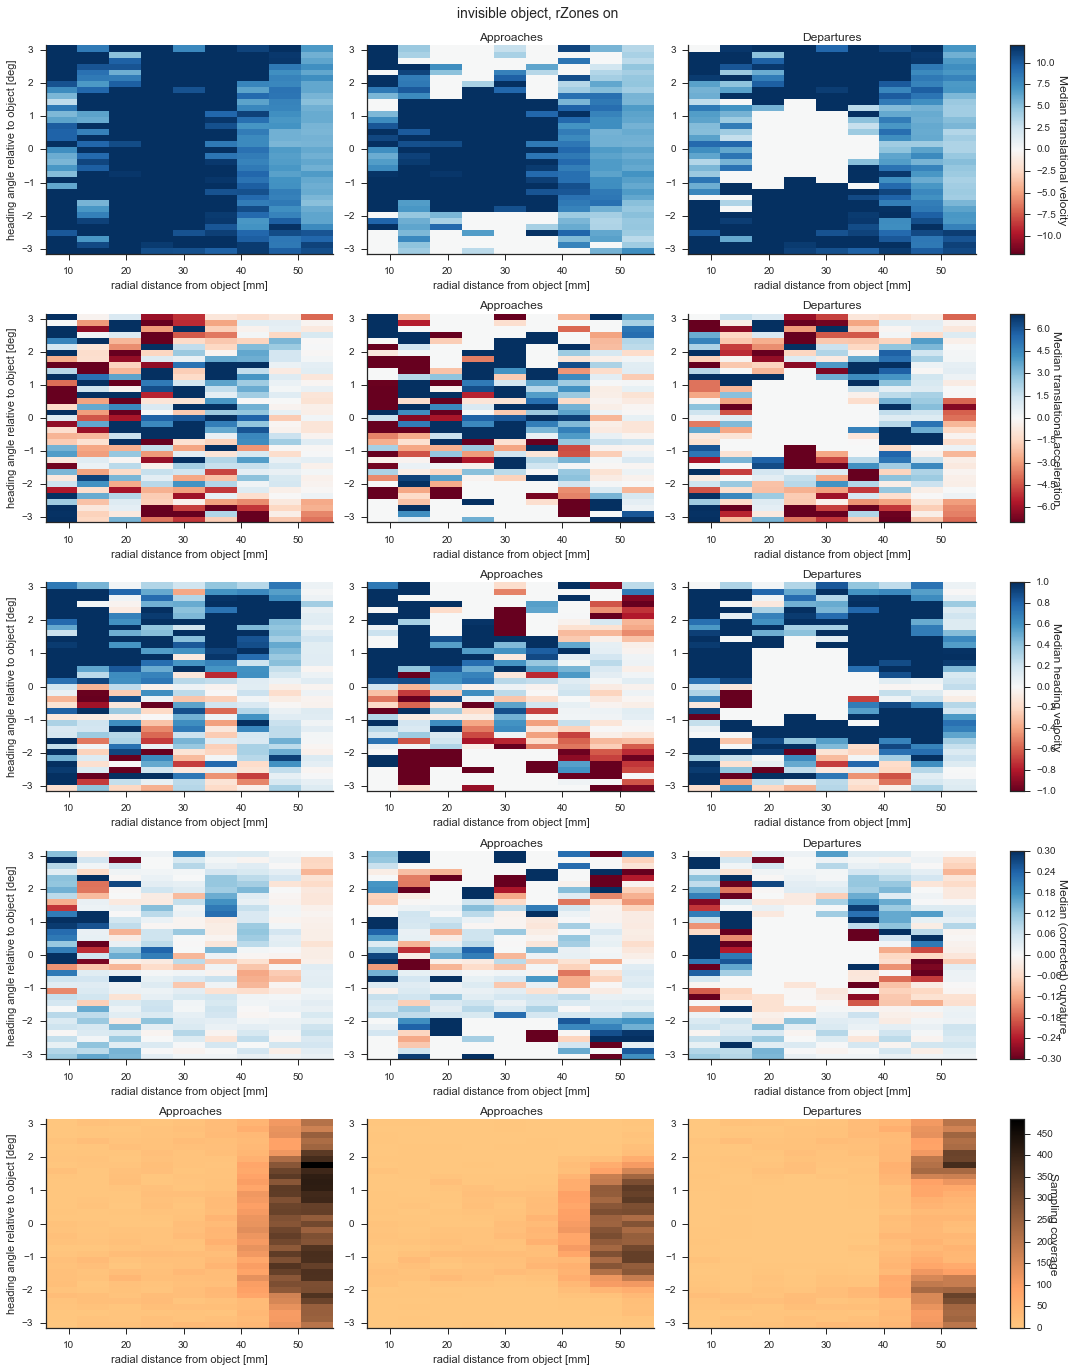

In [34]:
trialtype = 'invisible'
trial = 4

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, rZones ' + rZoneState[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_'+trialtype+'Objects_rZone'
                      +rZoneState[trial-1]+'_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

### Per-fly comparison between trials

/Users/hannah/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:689: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


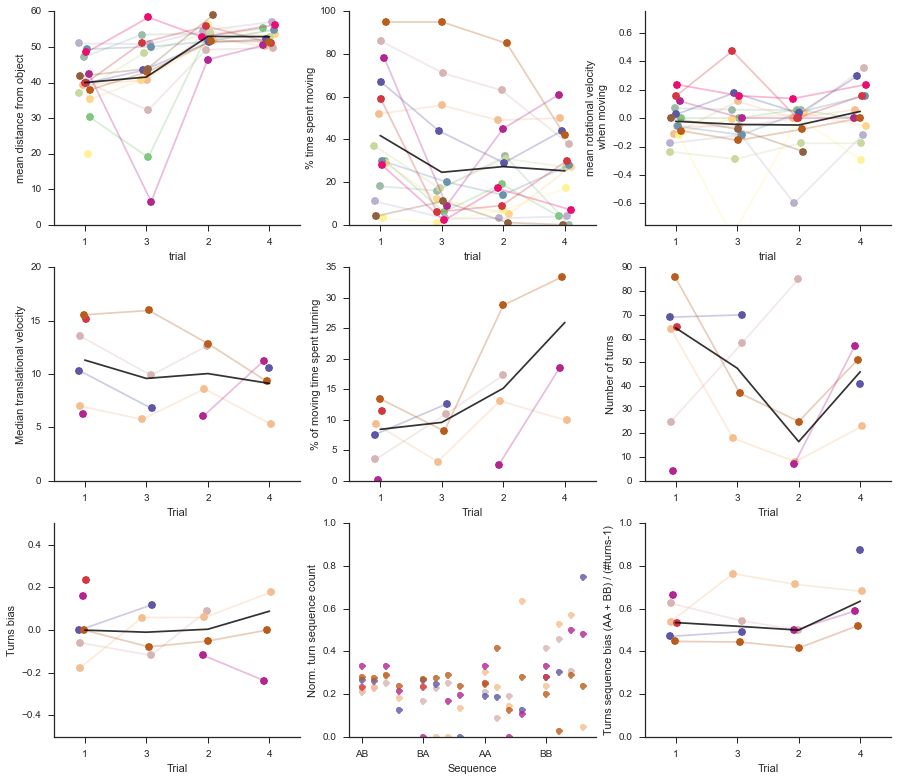

In [35]:
# make fly summary plot of residency:
arenaRad = 60
numtrials = len(visibilityState)
numVItrials = sum(['visible' in visibilityState[trial] for trial in range(len(visibilityState))])
numIVtrials = len(visibilityState)-numVItrials

minTurnDist = 5

trialComparisonFig = plt.figure(figsize=(15,13))
gs = gridspec.GridSpec(3,3) #,width_ratios=[1,0.9])

nTrial = [nTrialsNR/2, nTrialsNR/2,nTrialsR/2, nTrialsIN]

# Top row plots: ...............................................................................................

# Plots of (a) percent of time spent moving, (b) rotational bias and (c) mean distance from object
percentMoving = np.zeros((numFlies,numtrials))
rotationBias = np.zeros((numFlies,numtrials))
meanObjDist = np.zeros((numFlies,numtrials))
jitter = np.zeros((numFlies,numtrials))

perFlyMeanDistPlt = trialComparisonFig.add_subplot(gs[0,0])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[0,1])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

perFlyRotBiasPlt = trialComparisonFig.add_subplot(gs[0,2])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')


for fly in range(numFlies):
    for trial in range(numtrials):

        tJitter = np.random.uniform(-0.1, 0.1)
        jitter[fly,trial] = tJitter
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float')
        perFlyObjDist = FOAllFlies_df.query(querystring).iloc[:,keyind_objD:keyind_objD+1].squeeze().astype('float')
        
        percentMoving[fly,trial] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        rotationBias[fly,trial] = np.nanmedian(perFlyRot)
        meanObjDist[fly,trial] = np.nanmedian(perFlyObjDist)
        
        perFlyMovingPlt.plot(trial+1+tJitter,percentMoving[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))

        perFlyRotBiasPlt.plot(trial+1+tJitter,rotationBias[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))
        
        perFlyMeanDistPlt.plot(trial+1+tJitter,meanObjDist[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))
        
        
    perFlyMovingPlt.plot(range(1,numtrials+1)+jitter[fly,:],percentMoving[fly,:],
                         '-',markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    
    perFlyRotBiasPlt.plot(range(1,numtrials+1)+jitter[fly,:] ,rotationBias[fly,:],'-',
                          markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
        
    perFlyMeanDistPlt.plot(range(1,numtrials+1)+jitter[fly,:],meanObjDist[fly,:],'-',
                         markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    
    
#plot average response
perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyRotBiasPlt.plot(range(1,numtrials+1),np.nanmean(rotationBias,axis=0),color='k',alpha=0.8)
perFlyMeanDistPlt.plot(range(1,numtrials+1),np.nanmean(meanObjDist,axis=0),color='k',alpha=0.8)

# Beautify axes
perFlyMeanDistPlt.set_ylim(0,arenaRad)
perFlyMeanDistPlt.set_xlim(0.5,numtrials+0.5)
perFlyMeanDistPlt.set_xlabel('trial')
perFlyMeanDistPlt.set_ylabel('mean distance from object')
myAxisTheme(perFlyMeanDistPlt)

perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
perFlyMovingPlt.set_xlabel('trial')
perFlyMovingPlt.set_ylabel('% time spent moving')
myAxisTheme(perFlyMovingPlt)

perFlyRotBiasPlt.set_ylim(-0.75,0.75)
perFlyRotBiasPlt.set_xlim(0.5,numtrials+0.5)
perFlyRotBiasPlt.set_xlabel('trial')
perFlyRotBiasPlt.set_ylabel('mean rotational velocity \n when moving')
myAxisTheme(perFlyRotBiasPlt)

# Bottom row plots: ...............................................................................................

# Only include moving flies
querystring = '(moving > 0)'
vRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
time = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

# Find turnTH over all flies
vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')
turnTH_pos = 2*np.std(vRot_filt[vRot_filt>=0])
turnTH_neg = -2*np.std(vRot_filt[vRot_filt<=0])

percentMoving = np.zeros((numFlies,numtrials))
perFlyTurnTH = np.zeros((numFlies,numtrials))
perFlyNumTurn = np.zeros((numFlies,numtrials))
perFlyTurnDir = np.zeros((numFlies,numtrials))
perFlyTurnSeqBias = np.zeros((numFlies,numtrials))

randJitter = np.zeros((numFlies,numtrials))

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[1,0])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
perFlyTurnTHPlt = trialComparisonFig.add_subplot(gs[1,1])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
perFlyNumTurnPlt = trialComparisonFig.add_subplot(gs[1,2])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

perFlyTurnDirPlt = trialComparisonFig.add_subplot(gs[2,0])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
perFlyTurnSeqPlt = trialComparisonFig.add_subplot(gs[2,1])
plt.xticks([0,1,2,3],['AB','BA','AA','BB'])
perFlyTurnSeqBiasPlt = trialComparisonFig.add_subplot(gs[2,2])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

for fly in range(numFlies):
    for trial in range(numtrials):
        
        jitter = np.random.uniform(-0.1, 0.1)
        randJitter[fly,trial] = jitter
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        
        if 100*sum(perFlyMoving)/max(1,len(perFlyMoving)) < 40:
            percentMoving[fly,trial] = np.nan
            perFlyTurnTH[fly,trial] = np.nan
            perFlyNumTurn[fly,trial] = np.nan
            perFlyTurnDir[fly,trial] = np.nan
            perFlyTurnSeqBias[fly,trial] = np.nan
            
            continue

        querystring = \
            '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +\
            '") & (moving > 0) & (objectDistance >= 20) & (objectDistance <= 50)'
        perFlyTra = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze().astype('float').values
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
        
        perFlyRot_filt = np.convolve(perFlyRot, np.ones((5,))/5, mode='same')
        
        turnMask = np.logical_or(perFlyRot_filt>turnTH_pos,perFlyRot_filt<turnTH_neg)
        turnLoc = np.where(turnMask>0)[0]
        turnStart = turnLoc[np.where(np.hstack((0,np.diff(turnLoc)))>minTurnDist)[0]]
        turnSide = np.sign(perFlyRot[turnStart])
        
        try:
            turnSeq = np.zeros(len(turnStart)-1)
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==0.5)[0]] = 2
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-0.5)[0]] = 3
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-1.5)[0]] = 0
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-2.5)[0]] = 1
            
            numBin = 4
            [n,edgs] = np.histogram(turnSeq,bins=numBin)
        
        except ValueError:
            print('Not enought turns in fly' + str(fly))
            n = np.ones(numBin)*np.nan
            
        perFlyTurnTH[fly,trial] = 100.0*(sum(perFlyRot_filt>turnTH_pos) + sum(perFlyRot_filt<turnTH_neg))/max(1,len(perFlyRot_filt))
        perFlyNumTurn[fly,trial] = len(turnStart)
        perFlyTurnDir[fly,trial] = np.nanmedian(perFlyRot)
        #abs((1.0*sum(perFlyRot_filt>turnTH_pos) - sum(perFlyRot_filt<turnTH_neg))/
        #                               max(1.0*sum(perFlyRot_filt>turnTH_pos) + sum(perFlyRot_filt<turnTH_neg),1))
        perFlyTurnSeqBias[fly,trial] = float(sum(n[2:]))/sum(n)
        
        alphaVal = min(perFlyNumTurn[fly,trial]/3,1)
        
        percentMoving[fly,trial] = np.nanmedian(perFlyTra)
        
        perFlyMovingPlt.plot(trial+1+jitter,percentMoving[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        
        perFlyTurnTHPlt.plot(trial+1+jitter,perFlyTurnTH[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyNumTurnPlt.plot(trial+1+jitter,perFlyNumTurn[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyTurnDirPlt.plot(trial+1+jitter,perFlyTurnDir[fly,trial],'.',
                              markersize=15,color = flyCMap.to_rgba(fly))
        
        perFlyTurnSeqPlt.plot(range(numBin)+np.ones(numBin)*0.2*trial,n/(np.ones(numBin)*sum(n)),
                              marker = 'o',linestyle='none',alpha = 0.8,color = flyCMap.to_rgba(fly))
        
        perFlyTurnSeqBiasPlt.plot(trial+1+jitter,perFlyTurnSeqBias[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        
    perFlyMovingPlt.plot(range(1,numtrials+1)+randJitter[fly,:],percentMoving[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)    
    perFlyTurnTHPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnTH[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyNumTurnPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyNumTurn[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyTurnDirPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnDir[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnSeqBias[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    
#plot average response
perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyTurnTHPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnTH,axis=0),color='k',alpha=0.8)
perFlyNumTurnPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyNumTurn,axis=0),color='k',alpha=0.8)
perFlyTurnDirPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnDir,axis=0),color='k',alpha=0.8)
perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnSeqBias,axis=0),color='k',alpha=0.8)

# Beautify axes
perFlyMovingPlt.set_ylim(0,20)
perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
perFlyMovingPlt.set_xlabel('Trial')
perFlyMovingPlt.set_ylabel('Median translational velocity')
myAxisTheme(perFlyMovingPlt)

perFlyTurnTHPlt.set_ylim(0,35)
perFlyTurnTHPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnTHPlt.set_xlabel('Trial')
perFlyTurnTHPlt.set_ylabel('% of moving time spent turning')
myAxisTheme(perFlyTurnTHPlt)

perFlyNumTurnPlt.set_xlim(0.5,numtrials+0.5)
perFlyNumTurnPlt.set_xlabel('Trial')
perFlyNumTurnPlt.set_ylabel('Number of turns')
myAxisTheme(perFlyNumTurnPlt)

perFlyTurnDirPlt.set_ylim(-0.5,0.5)
perFlyTurnDirPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnDirPlt.set_xlabel('Trial')
perFlyTurnDirPlt.set_ylabel('Turns bias')
myAxisTheme(perFlyTurnDirPlt)

perFlyTurnSeqPlt.set_ylim(0,1)
perFlyTurnSeqPlt.set_xlim(-0.2,numBin-0.2)
perFlyTurnSeqPlt.set_xlabel('Sequence')
perFlyTurnSeqPlt.set_ylabel('Norm. turn sequence count')
myAxisTheme(perFlyTurnSeqPlt)

perFlyTurnSeqBiasPlt.set_ylim(0,1)
perFlyTurnSeqBiasPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnSeqBiasPlt.set_xlabel('Trial')
perFlyTurnSeqBiasPlt.set_ylabel('Turns sequence bias (AA + BB) / (#turns-1)')
myAxisTheme(perFlyTurnSeqBiasPlt)

In [36]:
trialComparisonFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareAllTrials' + sep)
except OSError:
    print('Analysis directory already exists.')

trialComparisonFig.savefig(analysisDir+'compareAllTrials/'+genotype+'_'+flyIDs[0][0]
                   +'_allTrials'+'_n'+str(len(flyIDs))+'.pdf', format='pdf')

Analysis directory already exists.


#### Analysis of turn behaviour: identify individual turns, then identify turn direction (L, R) and switches between L and R turns

### TODO: Improve definition of turns; don't count all above-threshold events as individual turns

In [37]:
# Possible other metrics to look at:
#   -  locations of turns


In [38]:
fly = 5
querystring = '(moving > 0)'
perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
perFlytime = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

perFlyRot_filt = np.convolve(perFlyRot, np.ones((5,))/5, mode='same')

turnTH_pos = 2*np.std(perFlyRot_filt[perFlyRot_filt>=0])
turnTH_neg = -2*np.std(perFlyRot_filt[perFlyRot_filt<=0])

querystring = '(flyID == "' + flyIDs[fly] + '") & (trial == ' + str(2) + ') & (moving > 0)'
perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
perFlytime = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values
perFlyRot_filt = np.convolve(perFlyRot, np.ones((5,))/5, mode='same')

turnMask = np.logical_or(perFlyRot_filt>turnTH_pos,perFlyRot_filt<turnTH_neg)
turnMask_right = perFlyRot_filt<turnTH_neg
turnMask_left = perFlyRot_filt>turnTH_pos

In [39]:
# find sharp turn starts
minTurnDist = 5

turnLoc = np.where(turnMask>0)[0]
turnStart = turnLoc[np.where(np.hstack((0,np.diff(turnLoc)))>minTurnDist)[0]]

turnLocL = np.where(turnMask_left>0)[0]
turnStartL = turnLocL[np.where(np.hstack((0,np.diff(turnLocL)))>minTurnDist)[0]]

turnLocR = np.where(turnMask_right>0)[0]
turnStartR = turnLocR[np.where(np.hstack((0,np.diff(turnLocR)))>minTurnDist)[0]]

turnSide = np.sign(perFlyRot[turnStart])

18


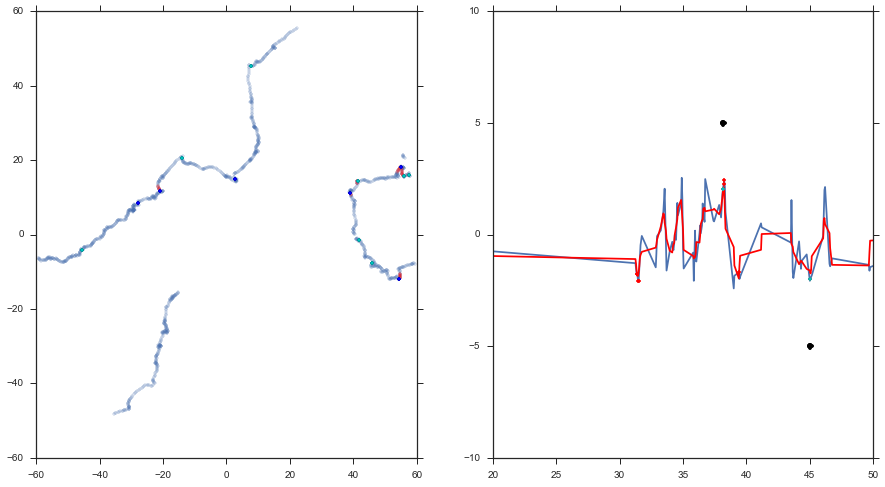

In [40]:
# Visualise detected turns
perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].squeeze().astype('float').values
perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].squeeze().astype('float').values

fig = plt.figure(figsize=(15,8))
fig.add_subplot(121)
plt.plot(perFlyX,perFlyY,'.',alpha=0.2)
plt.plot(perFlyX[turnMask],perFlyY[turnMask],'r.',alpha=0.2)
plt.plot(perFlyX[turnStart],perFlyY[turnStart],'k.')
plt.plot(perFlyX[turnStartL],perFlyY[turnStartL],'b.')
plt.plot(perFlyX[turnStartR],perFlyY[turnStartR],'c.')

fig.add_subplot(122)
plt.plot(perFlytime,perFlyRot)
plt.plot(perFlytime,perFlyRot_filt,'r')
plt.plot(perFlytime[perFlyRot_filt>turnTH_pos],perFlyRot[perFlyRot_filt>turnTH_pos],'r.')
plt.plot(perFlytime[perFlyRot_filt<turnTH_neg],perFlyRot[perFlyRot_filt<turnTH_neg],'r.')
plt.plot(perFlytime[turnStart],perFlyRot[turnStart],'c.')
plt.plot(perFlytime[turnStart],turnSide*5,'ko')
plt.xlim((20,50))
plt.ylim((-10,10))

print(len(turnStart))

In [41]:
from trajectoryDerivedParams import cartesian2polar, polarCurvature
from flyTracePlots import plotPolarTrace
from scipy.ndimage.filters import gaussian_filter

condition = "invisible"
rZone = "off"
querystring = \
 '(reinforcement=="'+rZone+'") & (trialtype=="'+condition+'")&(moving>0)&(objectDistance>6)'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
angleFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_ang:keyind_ang+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()


# Find turnTH over all flies
useTurnIndex = False
if useTurnIndex:
    vtrans = np.asarray(FOAllFlies_df.query(querystring).iloc[:, keyind_vT:keyind_vT+1]).squeeze()
    vRotFilt_ds = np.convolve(vRotFly/vTransFly, np.ones((5,))/5, mode='same')
    vRotFilt_ds[np.isinf(abs(vRotFilt_ds))] = 0.0
else:
    vRotFilt_ds = np.convolve(vRotFly, np.ones((5,))/5, mode='same')

turnTH_pos = 2*np.nanstd(vRotFilt_ds[vRotFilt_ds >= 0])
turnTH_neg = -2*np.nanstd(vRotFilt_ds[vRotFilt_ds <= 0])
turnTH = 2*np.nanstd(abs(vRotFilt_ds))

# transform trajectory to polar coordinates
objDist,theta = cartesian2polar(xPosFly,yPosFly)

# compute curvature
polarCurv, d_theta, dtheta_objDist = polarCurvature(theta,objDist)

d_objDist = np.hstack((0, np.diff(objDist)))

# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])

# Compute curvature-based criterion for turns
q2, q98 = np.percentile(polarCurv[~np.isnan(polarCurv)], [2 ,98])
curvSelect = abs(polarCurv)< (q98 - q2)/2

curvTurnMask_L = polarCurv > q98
curvTurnMask_R = polarCurv < q2

# Generate filtered curvature for plots and curvature magnitude
polarCurvPlt = polarCurv[curvSelect]

curvMag = abs(polarCurv)


selectPts_apr = d_objDist<0
selectPts_dep = d_objDist>0

selectPts_apr_turnR = np.logical_and(selectPts_apr,vRotFilt_ds < -2*turnTH)
selectPts_apr_turnL = np.logical_and(selectPts_apr,vRotFilt_ds > 2*turnTH)
selectPts_dep_turnR = np.logical_and(selectPts_dep,vRotFilt_ds < -2*turnTH)
selectPts_dep_turnL = np.logical_and(selectPts_dep,vRotFilt_ds > 2*turnTH)

fig = plt.figure(figsize=(15,10))

xlimRange = (5,60)
d_objDist = np.hstack((0, np.diff(objDist)))

ax=fig.add_subplot(211)
ax = plotPolarTrace(ax,genotype+', '+flyIDs[0][0] + '\nApproaches to ' + condition + ' object',
                selectPts_apr,selectPts_apr_turnR,selectPts_apr_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

ax=fig.add_subplot(212)
ax = plotPolarTrace(ax,'Departures from '+ condition + ' object',
                selectPts_dep,selectPts_dep_turnR,selectPts_dep_turnL,objDist,gammaFullFly,vRotFly,xlimRange)


ValueError: v cannot be empty

In [ ]:
makeNestedPlotDirectory(analysisDir, 'polarTrace/', 'rZones_'+ rZones + sep)

fig.savefig(analysisDir + 'polarTrace/'+genotype+'_'+flyIDs[0][0] + 'rZones_'+ rZones+sep
            +'_polarTrace'+'_n'+str(len(flyIDs))+'.pdf', format='pdf')

In [ ]:
condition = "visible"
rZone = "off"
querystring = \
 '(reinforcement=="'+rZone+'") & (trialtype=="'+condition+'")&(moving>0)&(objectDistance>5.5)'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
angleFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_ang:keyind_ang+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()


N = 5
vRotFilt_ds = np.convolve(vRotFly, np.ones((N,))/N, mode='same')

# transform trajectory to polar coordinates
objDist,theta = cartesian2polar(xPosFly,yPosFly)

# compute curvature
polarCurv, d_theta, dtheta_objDist = polarCurvature(theta,objDist)

d_objDist = np.hstack((0, np.diff(objDist)))

# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])

# Compute curvature-based criterion for turns
q2, q98 = np.percentile(polarCurv[~np.isnan(polarCurv)], [2 ,98])
curvSelect = abs(polarCurv)< (q98 - q2)/2

curvTurnMask_L = polarCurv > q98
curvTurnMask_R = polarCurv < q2

# Generate filtered curvature for plots and curvature magnitude
polarCurvPlt = polarCurv[curvSelect]

curvMag = abs(polarCurv)


selectPts_apr = d_objDist<0
selectPts_dep = d_objDist>0

selectPts_apr_turnR = np.logical_and(selectPts_apr,vRotFilt_ds < -2*turnTH)
selectPts_apr_turnL = np.logical_and(selectPts_apr,vRotFilt_ds > 2*turnTH)
selectPts_dep_turnR = np.logical_and(selectPts_dep,vRotFilt_ds < -2*turnTH)
selectPts_dep_turnL = np.logical_and(selectPts_dep,vRotFilt_ds > 2*turnTH)

fig = plt.figure(figsize=(15,10))

xlimRange = (5,60)
d_objDist = np.hstack((0, np.diff(objDist)))

ax=fig.add_subplot(211)
ax = plotPolarTrace(ax,genotype+', '+flyIDs[0][0] + '\nApproaches to ' + condition + ' object',
                selectPts_apr,selectPts_apr_turnR,selectPts_apr_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

ax=fig.add_subplot(212)
ax = plotPolarTrace(ax,'Departures from '+ condition + ' object',
                selectPts_dep,selectPts_dep_turnR,selectPts_dep_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

In [ ]:
makeNestedPlotDirectory(analysisDir, 'polarTrace/', 'rZones_'+ rZones + sep)

fig.savefig(analysisDir + 'polarTrace/'+genotype+'_'+flyIDs[0][0] + 'rZones_'+ rZones+sep
            +'_polarTrace'+'_n'+str(len(flyIDs))+'.pdf', format='pdf')ect related parameter